In [39]:
import os, sys
from getpass import getpass
import numpy as np
from math import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

!pip install -qq gpflow



datadir = './'

# code for running in Colab
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    if not os.path.exists("WildebeestCensus"):
        user = input('enter GitHub username: ')
        password = getpass('password: ')
        os.environ['git_user'] = user + ':' + password
        
        !git clone https://$git_user@github.com/GrantHopcraft/WildebeestCensus.git
    
    sys.path.append('WildebeestCensus')
    datadir = 'WildebeestCensus/SimData/'

except Exception:
    pass

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tfb = tfp.bijectors

import gpflow as gpf

print(tfp.__version__)
print(tf.__version__)
plt.style.use('seaborn-whitegrid')
#plt.style.available

0.12.1
2.4.1


## Load the data

In [72]:

inputfile = 'data/simdata_p9_r6.csv'#simdata_p1_r0.csv'
#inputfile = 'simdata_p223.csv'
#9,6

df =pd.read_csv(inputfile)
trueW = df[df.transect_id<0].wildebeest.values[0]
df = df[df.transect_id>0]

num_photo = len(df)
print(trueW)

1274358


## Also load the true positions for comparison to model output

In [73]:

# positions = np.loadtxt('pos.txt')
# positions = positions/1000

## Preprocess and plot the counts and positions

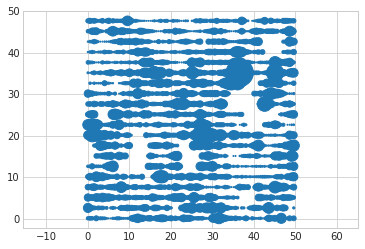

In [74]:
X = df[['x','y']].values/1000
wdata = df['wildebeest'].values[:,None].astype(np.float64)

plt.scatter(X[:,0],X[:,1],s=wdata)
plt.axis('equal')
plt.show()

areas = df.photo_area.values/1000/1000


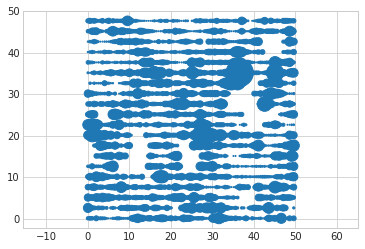

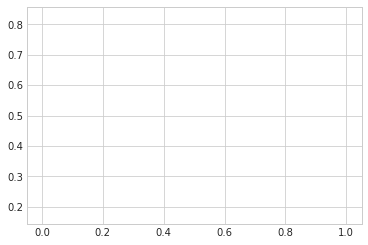

In [75]:

plt.scatter(X[:,0],X[:,1],s=wdata)
plt.axis('equal')
plt.show()

#plt.scatter(positions[:,0],positions[:,1],s=0.01,c='k')


plt.axis('equal')
plt.show()

## Create the likelihood

This is where the Zero-Inflated Poisson likelihood is created. It uses 2 latent fields (f and g) and uses them as inputs to a Mixture model which is a combination of Deterministic zeros and a Poisson distribution (see e.g. here https://github.com/tensorflow/probability/issues/1134)

In [76]:
from gpflow.config import default_float

class ZipLikelihood(gpf.likelihoods.MultiLatentTFPConditional):
    """
    Zero-inflated Poisson Likelihood where the conditional distribution
    is given by a TensorFlow Probability Distribution.
    The `presence` and `rate` of the distribution are given by a
    two-dimensional multi-output GP.
    """

    def __init__(
        self,
         binsize=1.0,
        **kwargs,
    ):
        """
        :param binsize: array of areas for Poisson distribution
        """
        self.binsize = np.reshape(np.array(binsize, dtype=default_float()),(-1,1))

        def conditional_distribution(Fs) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
            f = (Fs[..., :1])
            g = (Fs[..., 1:])
            
            g = tf.math.sigmoid(g)
            h = tf.stack((1-g,g),axis=-1)
            
            return tfd.Mixture(cat=tfd.Categorical(probs=(h)),
                                      components=[tfd.Deterministic(loc=tf.zeros_like((f))),
                                      tfd.Poisson(log_rate= (f + tf.math.log(self.binsize)))])


        super().__init__(
            latent_dim=2, conditional_distribution=conditional_distribution, **kwargs,
        )


## Create the model

We use default initial conditions for the kernels with initial mean values for the GPs taken from the data.

Priors are uniform but could be added.

In [77]:
data = (X, wdata)

# average intensity of images with wildebeest present
mean_log_intensity = np.log(wdata[wdata>0].sum()/areas[wdata[:,0]>0].sum())

# average probability of wildebeest present
p = wdata[wdata>0].shape[0]/wdata.shape[0]
p = min(0.99,p)
mean_presence = np.log(p/(1.000-p))


num_latent_gps=2

kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.Matern32(variance=1,lengthscales=1),   # This is k1, the kernel of f
        gpf.kernels.Matern32(variance=1,lengthscales=1),  # this is k2, the kernel of g
    ]
)

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(X),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(X),  # This is U2 = f2(Z2)
    ]
)

likelihood = ZipLikelihood(binsize=areas)

means = np.array([mean_log_intensity,mean_presence]).reshape((-1,1))

mean_fn = gpf.mean_functions.Constant(c=means)


svgp = gpf.models.SVGP(inducing_variable=inducing_variable,
                        kernel=kernel,
                        mean_function=mean_fn,
                        num_latent_gps=num_latent_gps,
                        likelihood = likelihood,whiten=True  )
f64 = np.float64
svgp.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(2.0), f64(0.5))
svgp.kernel.kernels[0].variance.prior = tfd.Gamma(f64(2.0), f64(2.0))

svgp.kernel.kernels[1].lengthscales.prior = tfd.Gamma(f64(2.0), f64(0.5))
svgp.kernel.kernels[1].variance.prior = tfd.Gamma(f64(2.0), f64(2.0))


gpf.set_trainable(svgp.inducing_variable.inducing_variable_list[0].Z,False)
gpf.set_trainable(svgp.inducing_variable.inducing_variable_list[1].Z,False)

gpf.utilities.print_summary(svgp)

╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════════╤═════════╤══════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape           │ dtype   │ value            │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════════╪═════════╪══════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity       │         │ True        │ (2, 1)          │ float64 │ [[6.39648576]    │
│                                                    │           │                │         │             │                 │         │  [2.20838541]]   │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[0].variance                    │ Parameter │ Sof

In [78]:
opt = gpf.optimizers.Scipy()
training_loss = svgp.training_loss_closure(data, compile=True)

opt.minimize(training_loss,variables=svgp.trainable_variables,options=dict(disp=True, maxiter=2000, gtol=1e-03),compile=True)


      fun: 7316.732611676977
 hess_inv: <4006006x4006006 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.44687454e-03,  3.41532835e-02, -1.37537815e-02, ...,
        1.87902179e-05,  1.01996719e-05, -3.66673213e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 898
      nit: 798
   status: 0
  success: True
        x: array([ 0.68445892,  0.46131641,  2.99167666, ..., -0.01369661,
       -0.01215614,  0.99593979])

In [79]:
gpf.set_trainable(svgp.kernel.kernels[1].variance,False)
gpf.utilities.print_summary(svgp)


╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape           │ dtype   │ value                                                │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity       │         │ True        │ (2, 1)          │ float64 │ [[5.89712875]                                        │
│                                                    │           │                │         │             │                 │         │  [6.68426974]]                                       │
├────────────────────────────────────────────

╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape           │ dtype   │ value                                                │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity       │         │ True        │ (2, 1)          │ float64 │ [[5.89712875]                                        │
│                                                    │           │                │         │             │                 │         │  [6.68426974]]                                       │
├────────────────────────────────────────────

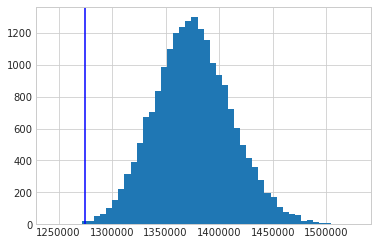

1437207.0
1317862.7999999998
1374570.0
1.079502220647573
1274358


In [80]:
gpf.utilities.print_summary(svgp)

ngrid=50
frac = 0.5*50/ngrid
pred_locations = np.array([np.linspace(frac,50-frac,ngrid),np.linspace(frac,50-frac,ngrid)])

xx, yy = np.meshgrid(pred_locations[0], pred_locations[1], sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()]).T

nsamp = 20000
y_pred = svgp.predict_f_samples(x_grid,nsamp).numpy()#+0.5*vgp.predict_f(x_grid)[1].numpy()
f_pred = y_pred[...,0]
g_pred = y_pred[...,1]



samples = tfd.Poisson(log_rate=np.log(50/ngrid)*2 + f_pred).sample()
samples = tf.where(tfd.Bernoulli(probs=tf.nn.sigmoid(g_pred)).sample()>0,samples,tf.zeros_like(samples))
totals = tf.reduce_sum(samples,axis=1).numpy()
plt.hist(totals,bins=50)
plt.axvline(trueW,c='b')
#plt.xlim(1e6,1.5e6)
plt.show()

print(np.percentile(totals,95))
print(np.percentile(totals,5))
print(np.percentile(totals,50))
print(np.mean(totals)/trueW)
print(trueW)



In [81]:
UCI = (np.percentile(totals,95))
LCI = (np.percentile(totals,5))
ml_est = (np.percentile(totals,50))
print(inputfile, ": True value: ", trueW, " ML GP estimate: ", ml_est, ml_est/trueW, " (95% CI: ", LCI, LCI/trueW, ",",UCI, UCI/trueW,")", flush=True)

data/simdata_p9_r6.csv : True value:  1274358  ML GP estimate:  1374570.0 1.0786372432236466  (95% CI:  1317862.7999999998 1.034138601554665 , 1437207.0 1.1277890514282485 )


In [24]:
# v1 = svgp.kernel.kernels[0].variance.numpy()
# v2 = svgp.kernel.kernels[1].variance.numpy()

# l1 = svgp.kernel.kernels[0].lengthscales.numpy()
# l2 = svgp.kernel.kernels[1].lengthscales.numpy()
# means = svgp.mean_function.c.numpy()


kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.Matern32(variance=v1,lengthscales=l1),  # This is k1, the kernel of f
        gpf.kernels.Matern32(variance=v2,lengthscales=l2),  # this is k2, the kernel of g

    ]
)
mean_fn = gpf.mean_functions.Constant(c=means)


svgp = gpf.models.SVGP(inducing_variable=inducing_variable,
                        kernel=kernel,
                        mean_function=mean_fn,
                        num_latent_gps=num_latent_gps,
                        likelihood = likelihood, q_diag=False  )

#gpf.set_trainable(svgp.trainable_parameters,False)
gpf.set_trainable(svgp.q_mu, True)
gpf.set_trainable(svgp.q_sqrt, True)



gpf.utilities.print_summary(svgp)



╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════════╤═════════╤═════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape           │ dtype   │ value               │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════════╪═════════╪═════════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity       │         │ True        │ (2, 1)          │ float64 │ [[ 8.26253386]      │
│                                                    │           │                │         │             │                 │         │  [-4.95829781]]     │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────────┼─────────┼─────────────────────┤
│ SVGP.kernel.kernels[0].variance                   

In [23]:
opt = gpf.optimizers.Scipy()
training_loss = svgp.training_loss_closure(data, compile=True)

opt.minimize(training_loss,variables=svgp.trainable_variables,options=dict(disp=True, maxiter=1000, gtol=1e-03),compile=True)


      fun: nan
 hess_inv: <4006006x4006006 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.5626697 , -0.51011719,         nan, ...,         nan,
               nan,         nan])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 654
      nit: 543
   status: 2
  success: False
        x: array([ 0.98060123, -0.47934449,  4.45966571, ..., -0.0054002 ,
       -0.00450273,  0.99806836])

In [56]:
gpf.set_trainable(svgp.trainable_parameters,False)
gpf.set_trainable(svgp.q_mu, True)
gpf.set_trainable(svgp.q_sqrt, True)



In [125]:
lr = 1e-2
adam_opt = tf.optimizers.Adam(lr)

In [71]:
#tf.linalg.cholesky(svgp.q_sqrt)

In [72]:
#aa = [tf.Variable(tf.identity(aaa)) for aaa in svgp.trainable_variables]
[tf.reduce_max(aaa) for aaa in  svgp.trainable_variables]

[<tf.Tensor: shape=(), dtype=float64, numpy=0.9279779786363674>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.7138401107881873>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.636708386063104>,
 <tf.Tensor: shape=(), dtype=float64, numpy=7.4411074070502865>,
 <tf.Tensor: shape=(), dtype=float64, numpy=8.14605696316379>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.8102330664230086>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.0000537604402415>]

In [75]:
[tf.debugging.check_numerics( tt,tt.name) for tt  in svgp.trainable_variables]

[<tf.Tensor: shape=(), dtype=float64, numpy=0.9279779786363674>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.7138401107881873>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.636708386063104>,
 <tf.Tensor: shape=(), dtype=float64, numpy=7.4411074070502865>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[ 8.14605696],
        [-5.51497019]])>,
 <tf.Tensor: shape=(2000, 2), dtype=float64, numpy=
 array([[-3.89020149e-03, -3.08264358e-01],
        [-3.74619602e-03, -9.53017734e-02],
        [-4.28949427e-03, -7.51294457e-02],
        ...,
        [ 3.98554699e-07, -2.48717515e-02],
        [ 2.52545226e-07, -1.57043142e-02],
        [ 9.76323581e-08, -6.32665307e-03]])>,
 <tf.Tensor: shape=(2, 2001000), dtype=float64, numpy=
 array([[ 9.99999996e-01, -6.59406361e-08, -7.70616824e-08, ...,
         -8.01646404e-08, -6.87184834e-08,  9.99999996e-01],
        [ 9.99499640e-01, -3.33172507e-03, -3.15602770e-03, ...,
         -4.69104107e-03, -4.60913109e-03,  9.98917458e-01]])>]

In [126]:

for i in range(100):
    with tf.GradientTape() as t:
        ll = training_loss
        a = t.gradient(ll(),svgp.trainable_variables)
    print('==========================================')
    print(a)
    adam_opt.apply_gradients(zip(a, svgp.trainable_variables))
    print([tf.reduce_max(aaa) for aaa in  svgp.trainable_variables])
    print([tf.debugging.check_numerics( tt,tt.name) for tt  in svgp.trainable_variables])


(<tf.Tensor: shape=(), dtype=float64, numpy=24.04072228042901>, <tf.Tensor: shape=(), dtype=float64, numpy=17.334616562208755>, <tf.Tensor: shape=(), dtype=float64, numpy=-2.7702012802643825>, <tf.Tensor: shape=(), dtype=float64, numpy=-3.023830999888362>, <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[80.77819798],
       [ 1.09238863]])>, <tf.Tensor: shape=(2000, 2), dtype=float64, numpy=
array([[ 4.63613312e-04,  2.59234826e-01],
       [ 1.06722776e-03,  1.47625091e-01],
       [ 1.83895417e-03,  1.19951025e-01],
       ...,
       [-2.28341419e-06, -1.07392204e-03],
       [-1.64111125e-06, -9.15385609e-04],
       [-7.61124018e-07, -5.00531096e-04]])>, <tf.Tensor: shape=(2, 2001000), dtype=float64, numpy=
array([[5.35289370e-07, 8.78730376e-07, 6.42707049e-07, ...,
        6.58189109e-07, 8.92315102e-07, 5.44500852e-07],
       [1.18663822e-03, 7.31128016e-05, 3.98185235e-04, ...,
        1.63764036e-03, 1.12082444e-03, 1.78435882e-03]])>)
[<tf.Tensor: shape=(), dtype=fl

InvalidArgumentError: Variable:0 : Tensor had NaN values [Op:CheckNumerics]

In [96]:
f_mean, f_var = svgp.predict_f(X)
var_exp = svgp.likelihood.variational_expectations(f_mean, f_var, wdata)

In [97]:
training_loss()
var_exp

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([-0.01485956, -0.0128081 , -0.01132842, ..., -0.7229006 ,
       -0.7135852 , -0.69747063])>

In [90]:
svgp.prior_kl()

<tf.Tensor: shape=(), dtype=float64, numpy=577.4933958833287>

In [57]:


lr = 1e-3
adam_opt = tf.optimizers.Adam(lr)

train_steps=100
report = 2

pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps//report))



training_loss = svgp.training_loss_closure(data, compile=True)

@tf.function
def optimization_step():
    adam_opt.minimize(training_loss, var_list=svgp.trainable_variables)

    
for i in pbar:


    optimization_step()
  

    if i % report == 0:
        elbo = -training_loss().numpy()
        loss_history[i//report] = -elbo#training_loss().numpy()
    
           
    pbar.set_description("%0.4f" % (-elbo))


nan: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]    


╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape           │ dtype   │ value                                                │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity       │         │ True        │ (2, 1)          │ float64 │ [[ 8.31122271]                                       │
│                                                    │           │                │         │             │                 │         │  [-2.41344589]]                                      │
├────────────────────────────────────────────

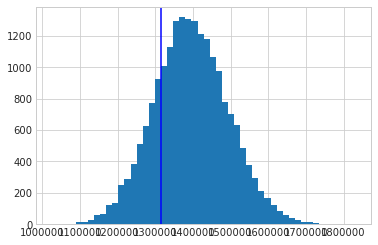

1560479.95
1235624.25
1392907.5
1.0600216610520525
1316208


In [106]:
gpf.utilities.print_summary(svgp)

ngrid=50
frac = 0.5*50/ngrid
pred_locations = np.array([np.linspace(frac,50-frac,ngrid),np.linspace(frac,50-frac,ngrid)])

xx, yy = np.meshgrid(pred_locations[0], pred_locations[1], sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()]).T

nsamp = 20000
y_pred = svgp.predict_f_samples(x_grid,nsamp).numpy()#+0.5*vgp.predict_f(x_grid)[1].numpy()
f_pred = y_pred[...,0]
g_pred = y_pred[...,1]



samples = tfd.Poisson(log_rate=np.log(50/ngrid)*2 + f_pred).sample()
samples = tf.where(tfd.Bernoulli(probs=tf.nn.sigmoid(g_pred)).sample()>0,samples,tf.zeros_like(samples))
totals = tf.reduce_sum(samples,axis=1).numpy()
plt.hist(totals,bins=50)
plt.axvline(trueW,c='b')
#plt.xlim(1e6,1.5e6)
plt.show()

print(np.percentile(totals,95))
print(np.percentile(totals,5))
print(np.percentile(totals,50))
print(np.mean(totals)/trueW)
print(trueW)



In [56]:
m1 = svgp.mean_function.c.numpy()
m1

gpf.set_trainable(svgp.trainable_parameters,False)

gpf.set_trainable(svgp.q_mu, True)
gpf.set_trainable(svgp.q_sqrt, True)

In [42]:
X.shape


# gpf.set_trainable(svgp.q_mu, False)
# gpf.set_trainable(svgp.q_sqrt, False)
# svgp.trainable_variables
svgp.q_mu.unconstrained_variable

<tf.Variable 'Variable:0' shape=(2000, 2) dtype=float64, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])>

In [58]:
opt = gpf.optimizers.Scipy()
training_loss = svgp.training_loss_closure(data, compile=True)
#variational_params = [svgp.q_mu.unconstrained_variable, svgp.q_sqrt.unconstrained_variable]

#opt.minimize(training_loss, variables=svgp.trainable_variables,options=dict(disp=True, maxiter=1))
#opt.minimize(training_loss, variables=variational_params,options=dict(disp=True, maxiter=100))
#svgp.trainable_variables


In [59]:
training_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=579366.069473672>

In [60]:
#@tf.function
def optimization_step():
    res = opt.minimize(training_loss,variables=svgp.trainable_variables,options=dict(disp=True, maxiter=100, gtol=1e-03),compile=True)
    return res

for i in tqdm(range(2)):
    
    res = optimization_step()#opt.minimize(training_loss, variables=svgp.trainable_variables,options=dict(disp=True, maxiter=100, gtol=1e-03),compile=True)
    print(res)
    if res.success: break

 50%|█████     | 1/2 [01:20<01:20, 80.60s/it]

      fun: 8484.724664998652
 hess_inv: <4006000x4006000 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.03573321, -0.01108019,  0.04322297, ...,  0.00179803,
        0.0027126 ,  0.00053468])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 102
      nit: 100
   status: 1
  success: False
        x: array([-0.27432953,  0.01962132,  0.05799352, ..., -0.00315103,
       -0.00467119,  0.99684834])


100%|██████████| 2/2 [02:40<00:00, 80.32s/it]

      fun: 8484.377305433856
 hess_inv: <4006000x4006000 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.62294833e-05, -5.21000807e-04,  1.86644026e-05, ...,
        7.17612061e-05,  1.26056854e-04, -6.05134758e-05])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 104
      nit: 100
   status: 1
  success: False
        x: array([-0.27420772,  0.0291255 ,  0.0565481 , ..., -0.00467915,
       -0.00700335,  0.99666159])


In [11]:
# for i in tqdm(range(100)):
    
#     res = opt.minimize(training_loss, variables=svgp.trainable_variables,options=dict(disp=True, maxiter=100, gtol=1e-03),compile=True)
#     if res.success: break

In [102]:
aa = opt.minimize(training_loss, variables=svgp.trainable_variables,options=dict(disp=True, maxiter=100, gtol=1e-03))

In [109]:
#variational_params

res

      fun: 2261.938154110588
 hess_inv: <4006006x4006006 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.89399518e+00,  3.59089374e-01, -2.47012379e-02, ...,
       -3.11151769e-04, -2.58174552e-04, -2.10474480e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 68
      nit: 60
   status: 0
  success: True
        x: array([ 1.59128891, -0.25965617,  4.77929146, ..., -0.00899268,
       -0.00770914,  0.99714262])

In [52]:
gpf.utilities.print_summary(svgp)

╒════════════════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════╕
│ name                                               │ class     │ transform   │ prior   │ trainable   │ shape     │ dtype   │ value                                │
╞════════════════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity    │         │ False       │ (2, 1)    │ float64 │ [[6.03046819]                        │
│                                                    │           │             │         │             │           │         │  [9.58374533]]                       │
├────────────────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────┤
│ SV

In [10]:
# from gpflow.optimizers import NaturalGradient
# natgrad_opt = NaturalGradient(gamma=1.0)
# variational_params = [(svgp.q_mu, svgp.q_sqrt)]
# # #


# training_loss = svgp.training_loss_closure(data, compile=True)

# variational_params = [(svgp.q_mu.unconstrained_variable, svgp.q_sqrt.unconstrained_variable)]

    
# # for i in tqdm(range(100)):

# #     #natgrad_opt.minimize(training_loss, var_list=variational_params)
    
# #     adam_opt.minimize(training_loss, var_list=variational_params)
# #     opt.minimize(training_loss,method='BFGS', variables=svgp.trainable_variables,options=dict(disp=True, maxiter=10))


In [32]:
#training_loss = svgp.training_loss_closure(data, compile=True)
variational_params = [(svgp.q_mu.unconstrained_variable, svgp.q_sqrt.unconstrained_variable)]

with tf.GradientTape() as t:
    ll = training_loss
    a = t.gradient(ll(),svgp.trainable_variables)
    
#adam_opt.minimize(training_loss, var_list=variational_params)


In [33]:
a
#ll()
#svgp.q_mu.unconstrained_variable

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.7335417408837657>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-4.021696867304854>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-1.5896038647868664>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.048474060929024176>,
 <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[ 0.376572 ],
        [-0.2125263]])>,
 <tf.Tensor: shape=(2000, 2), dtype=float64, numpy=
 array([[3.84742554e-06, 9.33570750e-03],
        [4.16279685e-06, 8.59308207e-03],
        [6.46195436e-06, 8.68452218e-03],
        ...,
        [1.25044739e-08, 2.41461895e-03],
        [1.34425010e-08, 1.67822688e-03],
        [1.04511803e-08, 7.29249107e-04]])>,
 <tf.Tensor: shape=(2000, 2), dtype=float64, numpy=
 array([[ 2.38228786e-06,  1.37583418e-03],
        [ 1.17135820e-06,  1.25690178e-03],
        [ 7.33752382e-07,  1.24167871e-03],
        ...,
        [-4.61981104e-08,  1.20689242e-03],
        [-5.24288252e-08,  7.98973206e-04],
        [-4.55925627e-08,  2.60120

In [186]:
gpf.set_trainable(svgp.inducing_variable.inducing_variable_list[0].Z,False)
gpf.set_trainable(svgp.inducing_variable.inducing_variable_list[1].Z,False)

gpf.utilities.print_summary(svgp)

╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape           │ dtype   │ value                                                │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════════╪═════════╪══════════════════════════════════════════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity       │         │ True        │ (2, 1)          │ float64 │ [[ 7.71391775]                                       │
│                                                    │           │                │         │             │                 │         │  [-1.19446508]]                                      │
├────────────────────────────────────────────

In [92]:
vgp.kernel.kernels[0]

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,"(1,)",float64,[5.]
Matern32.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1000. 1000.]


In [64]:
opt = gpf.optimizers.Scipy()
training_loss = svgp.training_loss_closure(data, compile=True)

opt.minimize(training_loss, variables=svgp.trainable_variables)


      fun: nan
 hess_inv: <4014006x4014006 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.25861768e-05,  1.50075665e-05, -1.15912135e-04, ...,
                   nan,             nan,             nan])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1151
      nit: 971
   status: 2
  success: False
        x: array([ 9.00001847e+01,  1.35000029e+02,  5.89999997e+02, ...,
       -7.08844893e-02, -1.07986754e-01,  9.21227694e-01])

In [98]:
vgp.data

(<tf.Tensor: shape=(2000, 2), dtype=float64, numpy=
 array([[   90.,   135.],
        [  590.,   135.],
        [ 1090.,   135.],
        ...,
        [48590., 47635.],
        [49090., 47635.],
        [49590., 47635.]])>,
 <tf.Tensor: shape=(2000, 1), dtype=float64, numpy=
 array([[35.],
        [30.],
        [75.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]])>)

In [99]:
#gpf.utilities.print_summary(svgp)
#svgp.kernel
opt = gpf.optimizers.Scipy()
#training_loss = vgp.training_loss_closure(data, compile=True)

opt.minimize(vgp.training_loss(), variables=vgp.trainable_variables)

InvalidArgumentError: Incompatible shapes: [2000,2,2] vs. [2000,2000] [Op:AddV2]

In [30]:
l1 = svgp.kernel.kernels[0].lengthscales.numpy()
v1

kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.Matern32(variance=v1,lengthscales=l1),   # This is k1, the kernel of f
        gpf.kernels.Matern32(variance=5),  # this is k2, the kernel of g
    ]
)
kernel

name,class,transform,prior,trainable,shape,dtype,value
SeparateIndependent.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.739616
SeparateIndependent.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.739616
SeparateIndependent.kernels[1].variance,Parameter,Softplus,,True,(),float64,5
SeparateIndependent.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1


## Next we optimize the model

In [17]:


lr = 1e-2
adam_opt = tf.optimizers.Adam(lr)

train_steps=200
report = 2

pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps//report))



training_loss = svgp.training_loss_closure(data, compile=True)

@tf.function
def optimization_step():
    adam_opt.minimize(training_loss, var_list=svgp.trainable_variables)

    
# from gpflow.optimizers import NaturalGradient
# natgrad_opt = NaturalGradient(gamma=1.0)
# variational_params = [(svgp.q_mu, svgp.q_sqrt)]
# # #


# gpf.set_trainable(svgp.q_mu, False)
# gpf.set_trainable(svgp.q_sqrt, False)


for i in pbar:


    optimization_step()
    #natgrad_opt.minimize(training_loss, var_list=variational_params)
    

    if i % report == 0:
        elbo = -training_loss().numpy()
        loss_history[i//report] = -training_loss().numpy()
    
           
    pbar.set_description("%0.4f" % (elbo))


-3730.9229: 100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


## Print optimised values

In [47]:
gpf.utilities.print_summary(svgp)


╒════════════════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═══════════╤═════════╤══════════════════════════════════════╕
│ name                                               │ class     │ transform   │ prior   │ trainable   │ shape     │ dtype   │ value                                │
╞════════════════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═══════════╪═════════╪══════════════════════════════════════╡
│ SVGP.mean_function.c                               │ Parameter │ Identity    │         │ True        │ (2, 1)    │ float64 │ [[6.03046819]                        │
│                                                    │           │             │         │             │           │         │  [9.58374533]]                       │
├────────────────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────┤
│ SV

## Plot samples from the optimised model

In [12]:
ngrid=50
pred_locations = np.array([np.linspace(0,50,ngrid),np.linspace(0,50,ngrid)])

xx, yy = np.meshgrid(pred_locations[0], pred_locations[1], sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()]).T

# predict the 2 latent functions       
y_pred = svgp.predict_f_samples(x_grid).numpy()
f_pred = y_pred[:,0]
g_pred = y_pred[:,1]



### First we'll plot the presence/absence field

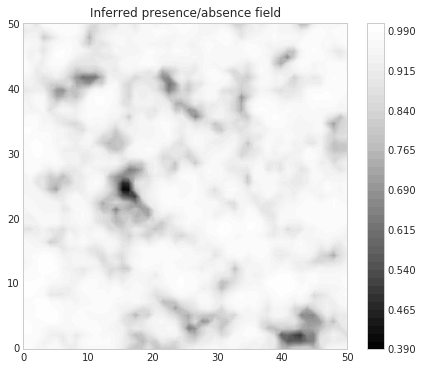

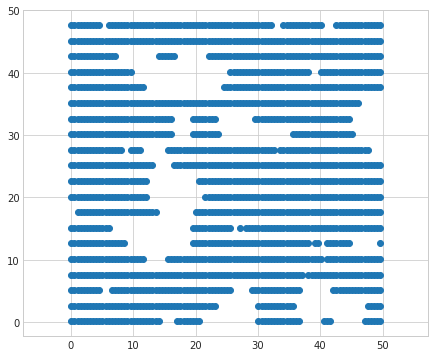

In [13]:
plt.figure(figsize=(7.25,6))

g_pred_sig = (tf.nn.sigmoid(g_pred).numpy().reshape(ngrid,ngrid))
plt.contourf(pred_locations[0], pred_locations[1], g_pred_sig,50,cmap='Greys_r')

plt.title('Inferred presence/absence field')
plt.colorbar()
plt.axis('equal')
plt.show()


plt.figure(figsize=(7.25,6))


#plt.hist2d(positions[:,0],positions[:,1],bins=100, vmax=1,cmap='Greys_r')
#plt.colorbar()
#plt.title('True presence/absence field')

plt.scatter(X[wdata[:,0]>0,0],X[wdata[:,0]>0,1])
plt.axis('equal')
plt.show()


### Next the log-intensity field

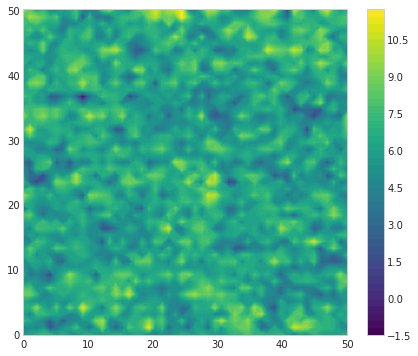

In [65]:

f_pred = (f_pred.reshape(ngrid,ngrid))
plt.figure(figsize=(7.25,6))
plt.contourf(pred_locations[0], pred_locations[1],f_pred,50,cmap='viridis')#,vmin=10)
plt.colorbar()
plt.axis('equal')
plt.show()

### Random samples of the abundance

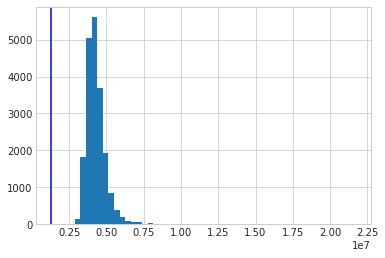

In [66]:
ngrid=50
frac = 0.5*50/ngrid
pred_locations = np.array([np.linspace(frac,50-frac,ngrid),np.linspace(frac,50-frac,ngrid)])

xx, yy = np.meshgrid(pred_locations[0], pred_locations[1], sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()]).T

nsamp = 20000
y_pred = svgp.predict_f_samples(x_grid,nsamp).numpy()#+0.5*vgp.predict_f(x_grid)[1].numpy()
f_pred = y_pred[...,0]
g_pred = y_pred[...,1]



samples = tfd.Poisson(log_rate=np.log(50/ngrid)*2 + f_pred).sample()
samples = tf.where(tfd.Bernoulli(probs=tf.nn.sigmoid(g_pred)).sample()>0,samples,tf.zeros_like(samples))
totals = tf.reduce_sum(samples,axis=1).numpy()
plt.hist(totals,bins=50)
plt.axvline(trueW,c='b')
#plt.xlim(1e6,1.5e6)
plt.show()


In [62]:
print(np.percentile(totals,95))
print(np.percentile(totals,5))
print(np.percentile(totals,50))
print(np.mean(totals)/trueW)
print(trueW)

5491805.8
3505210.0500000003
4193984.0
3.3115194453740844
1305763


In [32]:
print(np.percentile(totals,95))
print(np.percentile(totals,5))
print(np.percentile(totals,50))
print(np.mean(totals))
print(trueW)

1345468.45
1315234.8499999999
1330205.0
1330115.584
1348826


array([[ 0.        ,  1.02040816,  2.04081633,  3.06122449,  4.08163265,
         5.10204082,  6.12244898,  7.14285714,  8.16326531,  9.18367347,
        10.20408163, 11.2244898 , 12.24489796, 13.26530612, 14.28571429,
        15.30612245, 16.32653061, 17.34693878, 18.36734694, 19.3877551 ,
        20.40816327, 21.42857143, 22.44897959, 23.46938776, 24.48979592,
        25.51020408, 26.53061224, 27.55102041, 28.57142857, 29.59183673,
        30.6122449 , 31.63265306, 32.65306122, 33.67346939, 34.69387755,
        35.71428571, 36.73469388, 37.75510204, 38.7755102 , 39.79591837,
        40.81632653, 41.83673469, 42.85714286, 43.87755102, 44.89795918,
        45.91836735, 46.93877551, 47.95918367, 48.97959184, 50.        ],
       [ 0.5       ,  1.5       ,  2.5       ,  3.5       ,  4.5       ,
         5.5       ,  6.5       ,  7.5       ,  8.5       ,  9.5       ,
        10.5       , 11.5       , 12.5       , 13.5       , 14.5       ,
        15.5       , 16.5       , 17.5       , 18.